# Unit 10: Least Sqaure Regression

In [1]:
from datascience import *
%matplotlib inline
path_data = 'https://gitlab.com/tae-public/data/raw/master/cs61/data8assets/textbook/chapters/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [2]:

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

### Least Squares Regression ###
In an earlier section, we developed formulas for the slope and intercept of the regression line through a *football shaped* scatter diagram. It turns out that the slope and intercept of the least squares line have the same formulas as those we developed, *regardless of the shape of the scatter plot*.

We saw this in the example about Little Women, but let's confirm it in an example where the scatter plot clearly isn't football shaped. For the data, we are once again indebted to the rich [data archive of Prof. Larry Winner](http://www.stat.ufl.edu/~winner/datasets.html) of the University of Florida. A [2013 study](http://digitalcommons.wku.edu/ijes/vol6/iss2/10/) in the International Journal of Exercise Science studied collegiate shot put athletes and examined the relation between strength and shot put distance. The population consists of 28 female collegiate athletes. Strength was measured by the the biggest amount (in kilograms) that the athlete lifted in the "1RM power clean" in the pre-season. The distance (in meters) was the athlete's personal best.

In [3]:
shotput = Table.read_table(path_data + 'shotput.csv')

In [4]:
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


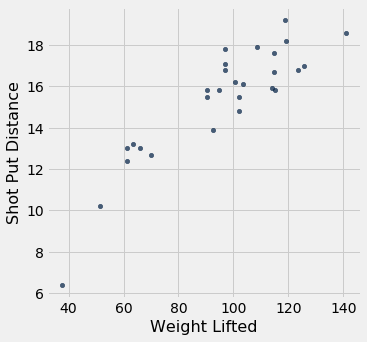

In [5]:
shotput.scatter('Weight Lifted')

That's not a football shaped scatter plot. In fact, it seems to have a slight non-linear component. But if we insist on using a straight line to make our predictions, there is still one best straight line among all straight lines.

Our formulas for the slope and intercept of the regression line, derived for football shaped scatter plots, give the following values.

In [6]:
slope(shotput, 'Weight Lifted', 'Shot Put Distance')

0.09834382159781997

In [7]:
intercept(shotput, 'Weight Lifted', 'Shot Put Distance')

5.959629098373952

Does it still make sense to use these formulas even though the scatter plot isn't football shaped? We can answer this by finding the slope and intercept of the line that minimizes the mse.

We will define the function `shotput_linear_mse` to take an arbirtary slope and intercept as arguments and return the corresponding mse. Then `minimize` applied to `shotput_linear_mse` will return the best slope and intercept.

In [8]:
def shotput_linear_mse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [9]:
minimize(shotput_linear_mse)

array([0.09834382, 5.95962911])

These values are the same as those we got by using our formulas. To summarize:

**No matter what the shape of the scatter plot, there is a unique line that minimizes the mean squared error of estimation. It is called the regression line, and its slope and intercept are given by**

$$
\mathbf{\mbox{slope of the regression line}} ~=~ r \cdot
\frac{\mbox{SD of }y}{\mbox{SD of }x}
$$

$$
\mathbf{\mbox{intercept of the regression line}} ~=~
\mbox{average of }y ~-~ \mbox{slope} \cdot \mbox{average of }x
$$

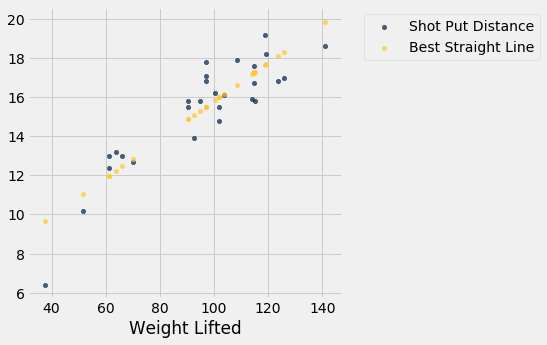

In [10]:
fitted = fit(shotput, 'Weight Lifted', 'Shot Put Distance')
shotput.with_column('Best Straight Line', fitted).scatter('Weight Lifted')

### Nonlinear Regression ###
The graph above reinforces our earlier observation that the scatter plot is a bit curved. So it is better to fit a curve than a straight line. The [study](http://digitalcommons.wku.edu/ijes/vol6/iss2/10/) postulated a quadratic relation between the weight lifted and the shot put distance. So let's use quadratic functions as our predictors and see if we can find the best one. 

We have to find the best quadratic function among all quadratic functions, instead of the best straight line among all straight lines. The method of least squares allows us to do this.

The mathematics of this minimization is complicated and not easy to see just by examining the scatter plot. But numerical minimization is just as easy as it was with linear predictors! We can get the best quadratic predictor by once again using `minimize`. Let's see how this works.

Recall that a quadratic function has the form

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.

To find the best quadratic function to predict distance based on weight lifted, using the criterion of least squares, we will first write a function that takes the three constants as its arguments, calculates the fitted values by using the quadratic function above, and then returns the mean squared error. 

The function is called `shotput_quadratic_mse`. Notice that the definition is analogous to that of `lw_mse`, except that the fitted values are based on a quadratic function instead of linear.

In [11]:
def shotput_quadratic_mse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = a*(x**2) + b*x + c
    return np.mean((y - fitted) ** 2)

We can now use `minimize` just as before to find the constants that minimize the mean squared error. 

In [12]:
best = minimize(shotput_quadratic_mse)
best

array([-1.04004838e-03,  2.82708045e-01, -1.53182115e+00])

Our prediction of the shot put distance for an athlete who lifts $x$ kilograms is about
$$
-0.00104x^2 ~+~ 0.2827x - 1.5318
$$
meters. For example, if the athlete can lift 100 kilograms, the predicted distance is 16.33 meters. On the scatter plot, that's near the center of a vertical strip around 100 kilograms.

In [13]:
(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

Here are the predictions for all the values of `Weight Lifted`. You can see that they go through the center of the scatter plot, to a rough approximation.

In [14]:
x = shotput.column(0)
shotput_fit = best.item(0)*(x**2) + best.item(1)*x + best.item(2)

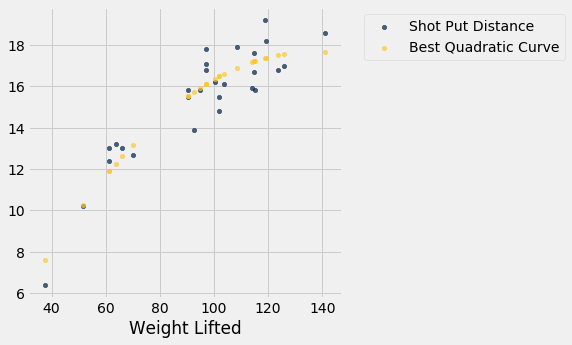

In [15]:
shotput.with_column('Best Quadratic Curve', shotput_fit).scatter(0)

# Unit 11: Visual Diagnostics

In [16]:

from datascience import *
path_data = 'https://gitlab.com/tae-public/data/raw/master/cs61/data8assets/textbook/chapters/'
import numpy as np
from scipy import stats

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [17]:
# HIDDEN 

galton = Table.read_table(path_data + 'galton.csv')
heights = galton.select('midparentHeight', 'childHeight')
heights = heights.relabel(0, 'MidParent').relabel(1, 'Child')
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [18]:

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

### Visual Diagnostics ###
Suppose a data scientist has decided to use linear regression to estimate values of one variable (called the response variable) based on another variable (called the predictor). To see how well this method of estimation performs, the data scientist must measure how far off the estimates are from the actual values. These differences are called *residuals*.

$$
\mbox{residual} ~=~ \mbox{observed value} ~-~ \mbox{regression estimate}
$$

A residual is what's left over – the residue – after estimation. 

Residuals are the vertical distances of the points from the regression line. There is one residual for each point in the scatter plot. The residual is the difference between the observed value of $y$ and the fitted value of $y$, so for the point $(x, y)$,

$$
\mbox{residual} ~~ = ~~ y ~-~
\mbox{fitted value of }y
~~ = ~~ y ~-~
\mbox{height of regression line at }x
$$

The function `residual` calculates the residuals. The calculation assumes all the relevant functions we have already defined: `standard_units`, `correlation`, `slope`, `intercept`, and `fit`.

In [19]:
def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

Continuing our example of using Galton's data to estimate the heights of adult children (the response) based on the midparent height (the predictor), let us calculate the fitted values and the residuals.

In [20]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


When there are so many variables to work with, it is always helpful to start with visualization. The function `scatter_fit` draws the scatter plot of the data, as well as the regression line. 

In [21]:
def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

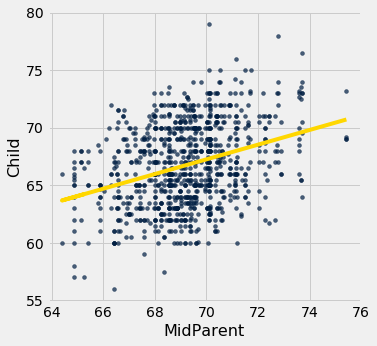

In [22]:
scatter_fit(heights, 'MidParent', 'Child')

A *residual plot* can be drawn by plotting the residuals against the predictor variable. The function `residual_plot` does just that. 

In [23]:
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

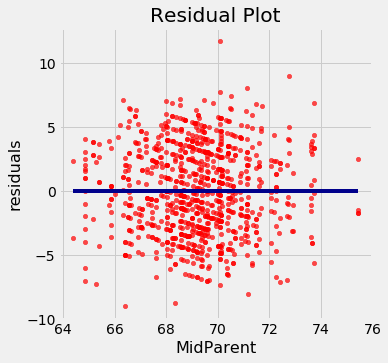

In [24]:
residual_plot(heights, 'MidParent', 'Child')

The midparent heights are on the horizontal axis, as in the original scatter plot. But now the vertical axis shows the residuals. Notice that the plot appears to be centered around the horizontal line at the level 0 (shown in dark blue). Notice also that the plot shows no upward or downward trend. We will observe later that this is true of all regressions.

### Regression Diagnostics ###
Residual plots help us make visual assessments of the quality of a linear regression analysis. Such assessments are called *diagnostics*. The function ``regression_diagnostic_plots`` draws the original scatter plot as well as the residual plot for ease of comparison.

In [25]:
def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)

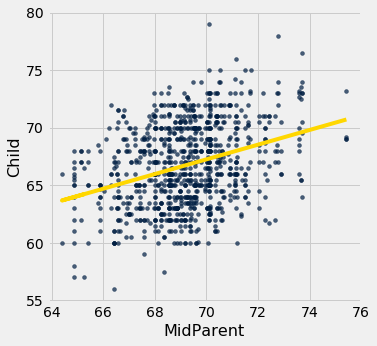

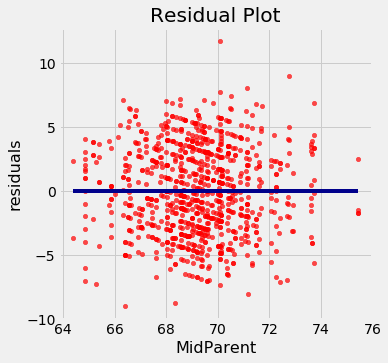

In [26]:
regression_diagnostic_plots(heights, 'MidParent', 'Child')

This residual plot indicates that linear regression was a reasonable method of estimation. Notice how the residuals are distributed fairly symmetrically above and below the horizontal line at 0, corresponding to the original scatter plot being roughly symmetrical above and below. Notice also that the vertical spread of the plot is fairly even across the most common values of the children's heights. In other words, apart from a few outlying points, the plot isn't narrower in some places and wider in others.

In other words, the accuracy of the regression appears to be about the same across the observed range of the predictor variable. 

**The residual plot of a good regression shows no pattern. The residuals look about the same, above and below the horizontal line at 0, across the range of the predictor variable.**

### Detecting Nonlinearity ###
Drawing the scatter plot of the data usually gives an indication of whether the relation between the two variables is non-linear. Often, however, it is easier to spot non-linearity in a residual plot than in the original scatter plot. This is usually because of the scales of the two plots: the residual plot allows us to zoom in on the errors and hence makes it easier to spot patterns.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Dugong_dugon.jpg"/>

Our data are a [dataset](http://www.statsci.org/data/oz/dugongs.html)  on the age and length of dugongs, which are marine mammals related to manatees and sea cows (image from [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Dugong_dugon.jpg)). The data are in a table called `dugong`. Age is measured in years and length in meters. Because dugongs tend not to keep track of their birthdays, ages are estimated based on variables such as the condition of their teeth.

In [27]:
dugong = Table.read_table('http://www.statsci.org/data/oz/dugongs.txt')
dugong = dugong.move_to_start('Length')
dugong

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5
2.27,4
2.15,5
2.26,5
2.35,7
2.47,8


If we could measure the length of a dugong, what could we say about its age? Let's examine what our data say. Here is a regression of age (the response) on length (the predictor). The correlation between the two variables is substantial, at 0.83.

In [28]:
correlation(dugong, 'Length', 'Age')

0.8296474554905714

High correlation notwithstanding, the plot shows a curved pattern that is much more visible in the residual plot.

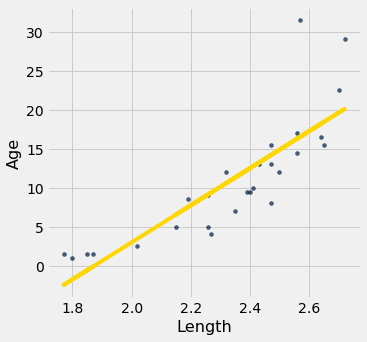

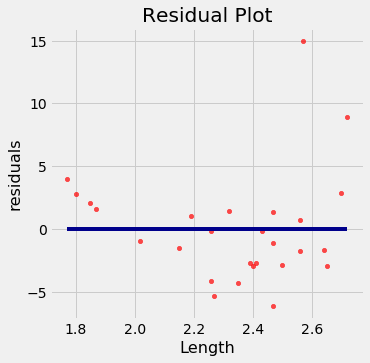

In [29]:
regression_diagnostic_plots(dugong, 'Length', 'Age')

While you can spot the non-linearity in the original scatter, it is more clearly evident in the residual plot.

At the low end of the lengths, the residuals are almost all positive; then they are almost all negative; then positive again at the high end of lengths. In other words the regression estimates have a pattern of being too high, then too low, then too high. That means it would have been better to use a curve instead of a straight line to estimate the ages.

**When a residual plot shows a pattern, there may be a non-linear relation between the variables.**

### Detecting Heteroscedasticity ###

*Heteroscedasticity* is a word that will surely be of interest to those who are preparing for Spelling Bees. For data scientists, its interest lies in its meaning, which is "uneven spread". 

Recall the table `hybrid` that contains data on hybrid cars in the U.S. Here is a regression of fuel efficiency on the rate of acceleration. The association is negative: cars that accelearate quickly tend to be less efficient.

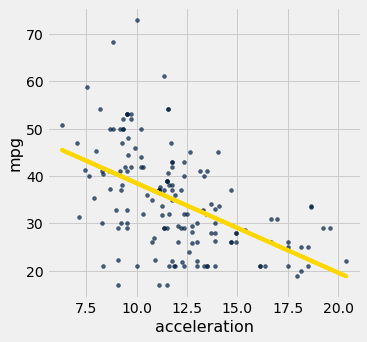

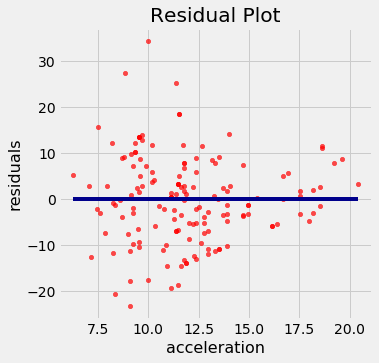

In [30]:
regression_diagnostic_plots(hybrid, 'acceleration', 'mpg')

Notice how the residual plot flares out towards the low end of the accelerations. In other words, the variability in the size of the errors is greater for low values of acceleration than for high values. Uneven variation is often more easily noticed in a residual plot than in the original scatter plot.

**If the residual plot shows uneven variation about the horizontal line at 0, the regression estimates are not equally accurate across the range of the predictor variable.**

# Unit 12: Numerical diagnostics

In [31]:

from datascience import *
path_data = 'https://gitlab.com/tae-public/data/raw/master/cs61/data8assets/textbook/chapters/'
import numpy as np
from scipy import stats

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [32]:
# HIDDEN 

galton = Table.read_table(path_data + 'galton.csv')
heights = galton.select('midparentHeight', 'childHeight')
heights = heights.relabel(0, 'MidParent').relabel(1, 'Child')
dugong = Table.read_table('http://www.statsci.org/data/oz/dugongs.txt')
dugong = dugong.move_to_start('Length')
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [33]:

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)
    
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)   

In [34]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )

### Numerical Diagnostics ###

In addition to visualization, we can use numerical properties of residuals to assess the quality of regression. We will not prove these properties mathematically. Rather, we will observe them by computation and see what they tell us about the regression.

All of the facts listed below hold for all shapes of scatter plots, whether or not they are linear.

### Residual Plots Show No Trend ###
**For every linear regression, whether good or bad, the residual plot shows no trend. Overall, it is flat. In other words, the residuals and the predictor variable are uncorrelated.** 

You can see this in all the residual plots above. We can also calculate the correlation between the predictor variable and the residuals in each case.



In [35]:
correlation(heights, 'MidParent', 'Residual')

-2.719689807647064e-16

That doesn't look like zero, but it is a tiny number that is 0 apart from rounding error due to computation. Here it is again, correct to 10 decimal places. The minus sign is because of the rounding that above.

In [36]:
round(correlation(heights, 'MidParent', 'Residual'), 10)

-0.0

In [37]:
dugong = dugong.with_columns(
       'Fitted Value', fit(dugong, 'Length', 'Age'),
       'Residual', residual(dugong, 'Length', 'Age')
)
round(correlation(dugong, 'Length', 'Residual'), 10)

0.0

### Average of Residuals ###
**No matter what the shape of the scatter diagram, the average of the residuals is 0.**

This is analogous to the fact that if you take any list of numbers and calculate the list of deviations from average, the average of the deviations is 0.

In all the residual plots above, you have seen the horizontal line at 0 going through the center of the plot. That is a visualization of this fact.

As a numerical example, here is the average of the residuals in the regression of children's heights based on parents' heights in Galton's dataset.

In [38]:
round(np.mean(heights.column('Residual')), 10)

0.0

The same is true of the average of the residuals in the regression of the age of dugongs on their length. The mean of the residuals is 0, apart from rounding error. 

In [39]:
round(np.mean(dugong.column('Residual')), 10)

0.0

### SD of the Residuals ###
**No matter what the shape of the scatter plot, the SD of the residuals is a fraction of the SD of the response variable. The fraction is  $\sqrt{1-r^2}$.**

$$
\mbox{SD of residuals} ~=~ \sqrt{1 - r^2} \cdot \mbox{SD of }y
$$

We will soon see how this measures the accuracy of the regression estimate. But first, let's confirm it by example. 

In the case of children's heights and midparent heights, the SD of the residuals is about 3.39 inches.

In [40]:
np.std(heights.column('Residual'))

3.3880799163953426

That's the same as $\sqrt{1-r^2}$ times the SD of response variable: 

In [41]:
r = correlation(heights, 'MidParent', 'Child')
np.sqrt(1 - r**2) * np.std(heights.column('Child'))

3.388079916395342

The same is true for the regression of mileage on acceleration of hybrid cars. The correlation $r$ is negative (about -0.5), but $r^2$ is positive and therefore $\sqrt{1-r^2}$ is a fraction.

In [42]:
r = correlation(hybrid, 'acceleration', 'mpg')
r

-0.5060703843771186

In [43]:
hybrid = hybrid.with_columns(
     'fitted mpg', fit(hybrid, 'acceleration', 'mpg'),
     'residual', residual(hybrid, 'acceleration', 'mpg')
)
np.std(hybrid.column('residual')), np.sqrt(1 - r**2)*np.std(hybrid.column('mpg'))

(9.43273683343029, 9.43273683343029)

Now let us see how the SD of the residuals is a measure of how good the regression is. Remember that the average of the residuals is 0. Therefore the smaller the SD of the residuals is, the closer the residuals are to 0. In other words, if the SD of the residuals is small, the overall size of the errors in regression is small.

The extreme cases are when $r=1$ or $r=-1$. In both cases, $\sqrt{1-r^2} = 0$. Therefore the residuals have an average of 0 and an SD of 0 as well, and therefore the residuals are all equal to 0. The regression line does a perfect job of estimation. As we saw earlier in this chapter, if $r = \pm 1$, the scatter plot is a perfect straight line and is the same as the regression line, so indeed there is no error in the regression estimate. 

But usually $r$ is not at the extremes. If $r$ is neither $\pm 1$ nor 0, then $\sqrt{1-r^2}$ is a proper fraction, and the rough overall size of the error of the regression estimate is somewhere between 0 and the SD of $y$.

The worst case is when $r = 0$. Then $\sqrt{1-r^2} =1$, and the SD of the residuals is equal to the SD of $y$. This is consistent with the observation that if $r=0$ then the regression line is a flat line at the average of $y$. In this situation, the root mean square error of regression is the root mean squared deviation from the average of $y$, which is the SD of $y$. In practical terms, if $r = 0$ then there is no linear association between the two variables, so there is no benefit in using linear regression.

### Another Way to Interpret $r$ ###
We can rewrite the result above to say that no matter what the shape of the scatter plot,

$$
\frac{\mbox{SD of residuals}}{\mbox{SD of }y} ~=~ \sqrt{1-r^2}
$$

A complementary result is that no matter what the shape of the scatter plot, the SD of the fitted values is a fraction of the SD of the observed values of $y$. The fraction is $\vert r \vert$.

$$
\frac{\mbox{SD of fitted values}}{\mbox{SD of }y} ~=~ \vert r \vert
$$

To see where the fraction comes in, notice that the fitted values are all on the regression line whereas the observed values of $y$ are the heights of all the points in the scatter plot and are more variable.

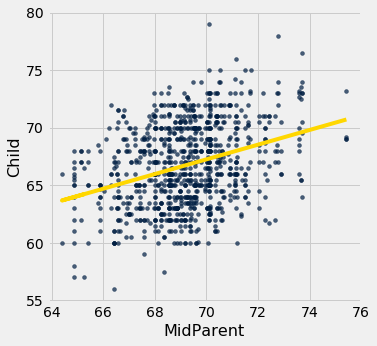

In [44]:
scatter_fit(heights, 'MidParent', 'Child')

The fitted values range from about 64 to about 71, whereas the heights of all the children are quite a bit more variable, ranging from about 55 to 80.

To verify the result numerically, we just have to calculate both sides of the identity.

In [45]:
correlation(heights, 'MidParent', 'Child')

0.32094989606395924

Here is ratio of the SD of the fitted values and the SD of the observed values of birth weight:

In [46]:
np.std(heights.column('Fitted Value'))/np.std(heights.column('Child'))

0.32094989606395957

The ratio is equal to $r$, confirming our result.

Where does the absolute value come in? First note that as SDs can't be negative, nor can a ratio of SDs. So what happens when $r$ is negative? The example of fuel efficiency and acceleration will show us.

In [47]:
correlation(hybrid, 'acceleration', 'mpg')

-0.5060703843771186

In [48]:
np.std(hybrid.column('fitted mpg'))/np.std(hybrid.column('mpg'))

0.5060703843771186

The ratio of the two SDs is $\vert r \vert$. 

A more standard way to express this result is to recall that 

$$
\mbox{variance} ~=~ \mbox{mean squared deviation from average} ~=~ \mbox{SD}^2
$$

and therefore, by squaring both sides of our result,

$$
\frac{\mbox{variance of fitted values}}{\mbox{variance of }y} ~=~ r^2
$$